In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Install the necessary packages
!pip install seaborn
!pip install contextily
!pip install pysal
!pip install osmnx
!pip install numpy==1.23.5
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import geopandas as gpd

import osmnx as ox

import pysal

import seaborn as sbn
import contextily as ctx
import matplotlib.pyplot as plt

In [4]:
#Upload the files you will work with

#Import crashes
db = pd.read_csv('/content/drive/MyDrive/Geospatial Data Science/Project progress/geoclean1619.csv')

#Import comunas
c = gpd.read_file('/content/drive/MyDrive/Geospatial Data Science/Project progress/catastro.geojson')

#Import neighborhoods
b = gpd.read_file('/content/drive/MyDrive/Geospatial Data Science/Project progress/barrios.geojson')

#Import the limits of Medellin
l = ox.geocode_to_gdf('Medellin, Colombia')

<ipython-input-4-33b9378fc27d>:4: DtypeWarning: Columns (14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  db = pd.read_csv('/content/drive/MyDrive/Geospatial Data Science/Project progress/geoclean1619.csv')


In [5]:
#Drop duplicated values within filed_id

db = db.drop_duplicates(subset=['filed_id'])

In [6]:
#Clean the coordinates that fall out of Medellin
db = db[db['latitude'] >= l['bbox_south'].iloc[0]]
db = db[db['latitude'] <= l['bbox_north'].iloc[0]]

db = db[db['longitude'] <= l['bbox_east'].iloc[0]]
db = db[db['longitude'] >= l['bbox_west'].iloc[0]]

In [7]:
#Create GeoDataFrame of the crashes
geo = gpd.points_from_xy(x=db['longitude'], y=db['latitude'], crs='EPSG:4326')

gdb = gpd.GeoDataFrame(db, geometry=geo)

In [8]:
gdb.head()

,Unnamed: 0,filed_id,record,year,month,day,date _dmy,hour,only_hour,only_minutes,...,accident_address,zone,city,area,type_of_facility,driver_age,driver_gender,longitude,latitude,geometry
0,0,1517737,A000301487,2016,1,1,2016-01-01,00:40:00,0,40,...,Carrera 41 Calle 84,Comuna 3 - Manrique,Medellin,Perímetro Urbano Medellín,Road_Segment,30.0,Male,-75.549371,6.275479,POINT (-75.54937 6.27548)
1,1,1517741,A000301491,2016,1,1,2016-01-01,01:00:00,1,0,...,Carrera 80 Calle 47 D,Comuna 12 - La América,Medellin,Perímetro Urbano Medellín,Road_Segment,30.0,Male,-75.597763,6.258443,POINT (-75.59776 6.25844)
3,3,1517739,A000301485,2016,1,1,2016-01-01,01:15:00,1,15,...,Calle 57 A Carrera 28,Comuna 8 - Villa Hermosa,Medellin,Perímetro Urbano Medellín,Road_Segment,23.0,Female,-75.548446,6.247266,POINT (-75.54845 6.24727)
4,4,1517734,A000301486,2016,1,1,2016-01-01,01:30:00,1,30,...,Calle 39 Carrera 119,Comuna 13 - San Javier,Medellin,Perímetro Urbano Medellín,Road_Segment,22.0,Male,-75.629323,6.249809,POINT (-75.62932 6.24981)
6,6,1517740,A000301488,2016,1,1,2016-01-01,02:00:00,2,0,...,Carrera 52 Calle 120 A,Comuna 2 - Santa Cruz,Medellin,Perímetro Urbano Medellín,Road_Segment,54.0,Male,-75.555730,6.305737,POINT (-75.55573 6.30574)


In [9]:
from shapely import wkt

gdb2 = gdb.to_crs('EPSG:3857')

gdb2['geometry'] = gdb2.geometry.apply(lambda x: wkt.dumps(x))

gdb2['geometry'] = gdb2['geometry'].astype('str')

rep = {'POINT':'', '(': '', ')': ''}

gdb2['geometry'] = gdb2['geometry'].apply(lambda x: x.replace('POINT', ''))

gdb2['geometry'] = gdb2['geometry'].apply(lambda x: x.replace('(', ''))

gdb2['geometry'] = gdb2['geometry'].apply(lambda x: x.replace(')', ''))

gdb2[['not', 'x', 'y']] = gdb2['geometry'].str.split(' ', expand=True)

db['x_p'] = gdb2['x']

db['y_p'] = gdb2['y']

#Convert new columns into numbers for further computations

db['x_p'] = db['x_p'].astype(float)
db['y_p'] = db['y_p'].astype(float)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [10]:
#Drop columns from comunas and barrios db

c = c.drop(['SECTOR', 'SHAPE__Area', 'SHAPE__Length'], axis=1)

#Filter columns out of Medellin

c['COMUNA'] = c['COMUNA'].astype(str).astype(int)

c = c[c['COMUNA'] <= 16]

b = b.drop(['INDICADOR_UR', 'SHAPE__Area', 'SHAPE__Length'], axis=1)

b['COMUNA'] = b['COMUNA'].astype(str).astype(int)

b = b[b['COMUNA'] <= 16]

b = b.reset_index()

In [11]:
#Create a join GeoDataFrame to capture the comuna and neighborhood attributes

gdb_c = gpd.sjoin(gdb, c, how='inner')

gdb_b = gpd.sjoin(gdb, b, how='inner')

##Centrography

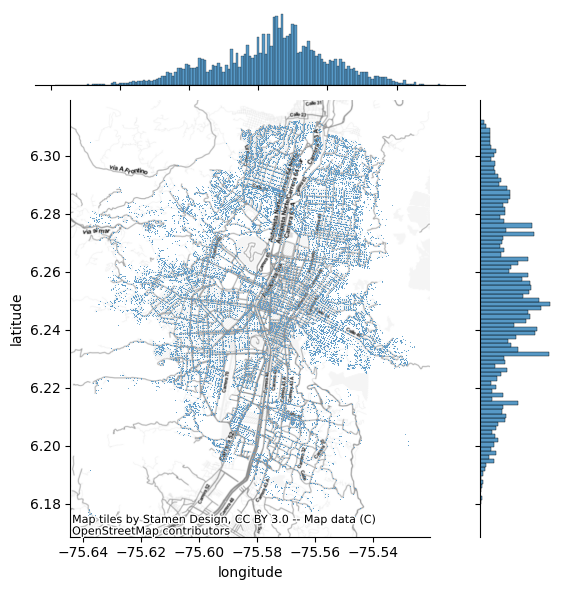

In [12]:
#Let's plot the distribution of the point pattern
data_scatter = sbn.jointplot(x='longitude',
                             y='latitude',
                             data=gdb,
                             s=0.5)

ctx.add_basemap(data_scatter.ax_joint,
                crs='EPSG:4326',
                source=ctx.providers.Stamen.TonerLite)

In [13]:
#Let's compute the centrography of our point pattern with projected crs

from pointpats import centrography

mean_center = centrography.mean_center(db[['x_p', 'y_p']])
med_center = centrography.euclidean_median(db[['x_p', 'y_p']])

In [14]:
#Then, compute the important parameters of the deviation ellipse

#Standard distance

std_d = centrography.std_distance(db[['x_p', 'y_p']])

std_d

3628.6367907897115

In [15]:
#Other important measures

#Major, minor and rotation of the ellipse

major, minor, rotation = centrography.ellipse(db[['x_p', 'y_p']])

In [16]:
major

2622.158533014422

In [17]:
minor

4285.836969407038

In [18]:
rotation

0.14938795581725348

/usr/local/lib/python3.10/dist-packages/contextily/plotting.py:282: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  draw()


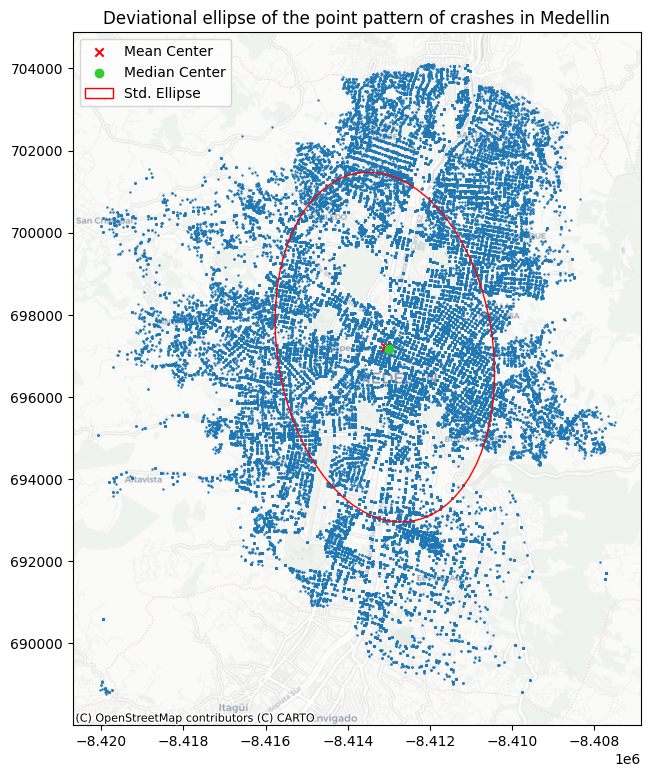

In [19]:
#Now, plot the point pattern and the deviational ellipse

from matplotlib.patches import Ellipse

f, ax = plt.subplots(1, figsize=(9,9))

#Plot crashes points

ax.scatter(db['x_p'], db['y_p'], s=0.5)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

#Construct the standar ellipse

ellipse = Ellipse(xy=mean_center,     #To center the ellipse on our mean center
                  width=major*2,
                  height=minor*2,
                  angle=np.rad2deg(rotation),
                  facecolor='none',
                  edgecolor='red',
                  linestyle='-',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

#Add basemap

ctx.add_basemap(ax,
                source=ctx.providers.CartoDB.Positron)

#Display

ax.set_title('Deviational ellipse of the point pattern of crashes in Medellin')

plt.show()

##Choroplets

In [20]:
#First, compute the total crashes by administrative division

#By comuna
crash_c = gdb_c.groupby('COMUNA').count()

crash_c = crash_c[['filed_id']]

crash_c.rename(columns={'filed_id': 'crashes'}, inplace=True)

crash_c = crash_c.reset_index()

c = c.merge(crash_c, on='COMUNA', how='inner')

#By neighborhood
crash_b = gdb_b.groupby('OBJECTID').count()

crash_b = crash_b[['filed_id']]

crash_b.rename(columns={'filed_id': 'crashes'}, inplace=True)

crash_b = crash_b.reset_index()

b = b.merge(crash_b, on='OBJECTID', how='inner')

In [21]:
len(crash_c)

16

In [22]:
c.head()

,OBJECTID,COMUNA,NOMBRE,geometry,crashes
0,2881,16,BELEN,"POLYGON ((-75.61844 6.23686, -75.61839 6.23685...",11998
1,2882,1,POPULAR,"POLYGON ((-75.55376 6.29002, -75.55319 6.29167...",2262
2,2883,7,ROBLEDO,"POLYGON ((-75.62050 6.27361, -75.62050 6.27361...",11734
3,2884,4,ARANJUEZ,"POLYGON ((-75.57081 6.27082, -75.57080 6.27085...",9815
4,2885,5,CASTILLA,"POLYGON ((-75.57648 6.28845, -75.57622 6.28837...",16706


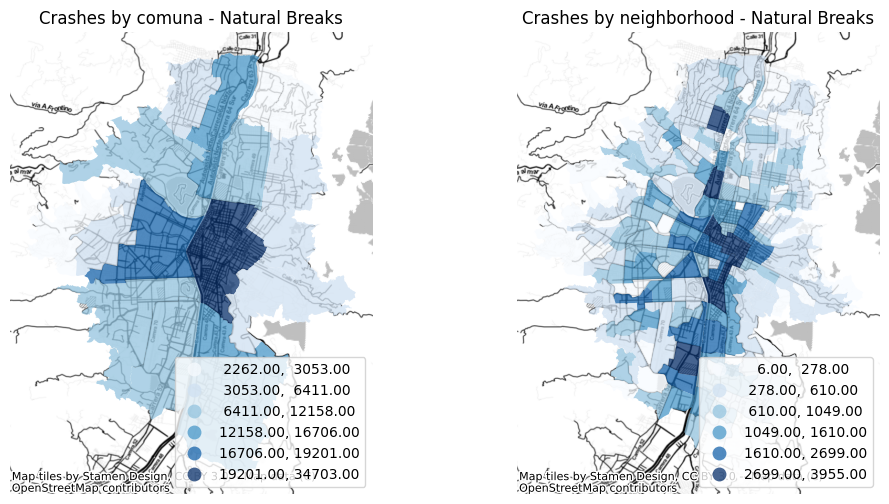

In [23]:
#Plot the crashes by comunas and neighborhoods of Medellin

f, axs = plt.subplots(1, 2, figsize=(12,6))

ax1, ax2 = axs

c.plot(column='crashes',
       cmap='Blues',
       scheme='naturalbreaks',
       k=6,
       edgecolor='white',
       linewidth=0,
       alpha=0.75,
       legend=True,
       ax=ax1,
       legend_kwds={'loc':4})

ax1.set_axis_off()
ax1.set_title('Crashes by comuna - Natural Breaks')

ctx.add_basemap(ax1,
                crs=c.crs,
                source=ctx.providers.Stamen.Toner)

b.plot(column='crashes',
       cmap='Blues',
       scheme='naturalbreaks',
       k=6,
       edgecolor='white',
       linewidth=0,
       alpha=0.75,
       legend=True,
       ax=ax2,
       legend_kwds={'loc':4})

ax2.set_axis_off()
ax2.set_title('Crashes by neighborhood - Natural Breaks')

ctx.add_basemap(ax2,
                crs=b.crs,
                source=ctx.providers.Stamen.Toner)

In [24]:
#Compute crash density for each approach
#Use projected coordinates EPSG:3116 Magna-Sirgas

#By comuna
c['area_sqkm'] = c.to_crs(epsg=3116).area*1e-6

c['crash_density'] = c['crashes']/c['area_sqkm']

#By neighborhood
b['area_sqkm'] = b.to_crs(epsg=3116).area*1e-6

b['crash_density'] = b['crashes']/b['area_sqkm']

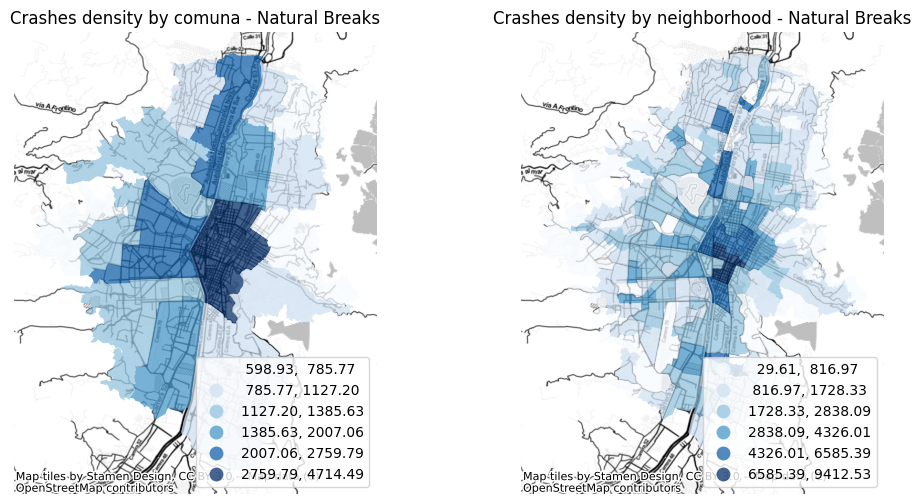

In [25]:
#Plot the density of crashes by comunas and neighborhoods of Medellin

f, axs = plt.subplots(1, 2, figsize=(12,6))

ax1, ax2 = axs

c.plot(column='crash_density',
       cmap='Blues',
       scheme='naturalbreaks',
       k=6,
       edgecolor='white',
       linewidth=0,
       alpha=0.75,
       legend=True,
       ax=ax1,
       legend_kwds={'loc':4})

ax1.set_axis_off()
ax1.set_title('Crashes density by comuna - Natural Breaks')

ctx.add_basemap(ax1,
                crs=c.crs,
                source=ctx.providers.Stamen.Toner)

b.plot(column='crash_density',
       cmap='Blues',
       scheme='naturalbreaks',
       k=6,
       edgecolor='white',
       linewidth=0,
       alpha=0.75,
       legend=True,
       ax=ax2,
       legend_kwds={'loc':4})

ax2.set_axis_off()
ax2.set_title('Crashes density by neighborhood - Natural Breaks')

ctx.add_basemap(ax2,
                crs=b.crs,
                source=ctx.providers.Stamen.Toner)

##Kernel Density Estimation (KDE)

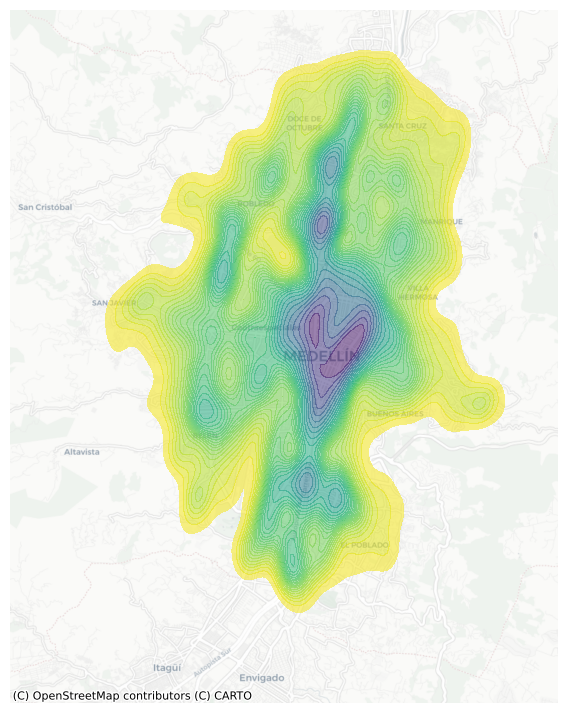

In [26]:
#This method helps in alleviating the Modifiable Areal Unit Problem (M.A.U.P)
#It works with projected crs

f, ax = plt.subplots(1, figsize=(9,9))

sbn.kdeplot(x=db['x_p'],
            y=db['y_p'],
            n_levels=30,
            fill=True,
            alpha=0.55,
            cmap='viridis_r')

ctx.add_basemap(ax,
                source=ctx.providers.CartoDB.Positron)

ax.set_axis_off()

##Clustering and Randomness

In [27]:
#Compute the convex hull for our data

#Do this exercise for two opposite neighbors

b_clusters = gdb_b[gdb_b['OBJECTID'] == 6823]

b_clusters = b_clusters.merge(db[['filed_id', 'x_p', 'y_p']], on='filed_id')

b_clusters = b_clusters.drop_duplicates(subset='filed_id')

hull_pol = centrography.hull(b_clusters[['x_p', 'y_p']].values)

In [28]:
coor = b_clusters[['x_p', 'y_p']].values

In [29]:
#Also compute the alpha shape

import libpysal

alpha_shape, alpha, circs = libpysal.cg.alpha_shape_auto(coor, return_circles=True)

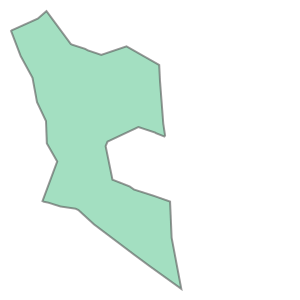

In [30]:
alpha_shape

In [31]:
from pointpats import distance_statistics, QStatistic, random, PointPattern

random_pattern_ashape = random.poisson(alpha_shape, size=len(coor))

<function matplotlib.pyplot.show(close=None, block=None)>

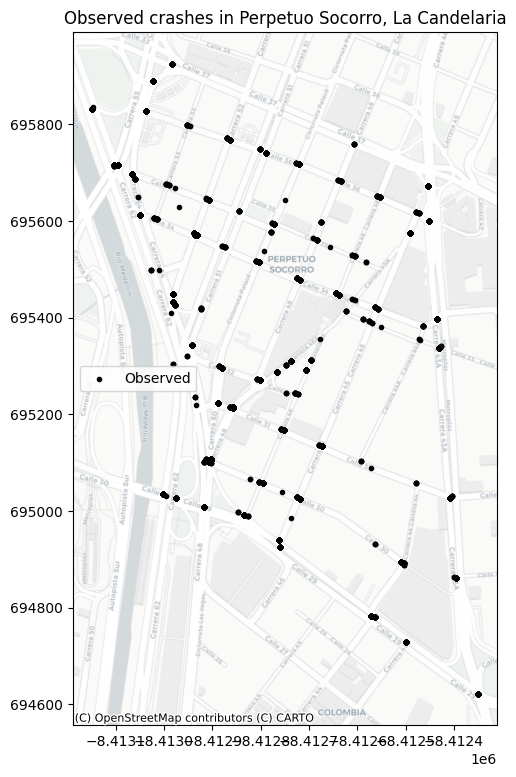

In [36]:
f, ax = plt.subplots(1, figsize=(9,9))

plt.scatter(*coor.T, color='k', marker='.', label='Observed')

#plt.scatter(*random_pattern_ashape.T,
#            color='r',
#            marker='x',
#            label='Random',
#            s=0.2)

ctx.add_basemap(ax,
                source=ctx.providers.CartoDB.Positron)

ax.legend(ncol=1,
          loc='center left')

ax.set_title('Observed crashes in Perpetuo Socorro, La Candelaria')

plt.show

In [41]:
b.sort_values(by=['crashes'], ascending=False).head(5)

,index,OBJECTID,CODIGO,COMUNA,BARRIO,NOMBRE_BARRIO,SECTOR,NOMBRE_COMUNA,geometry,crashes,area_sqkm,crash_density
111,148,6901,1019,10,19,La Candelaria,3,LA CANDELARIA,"POLYGON ((-75.56726 6.25403, -75.56737 6.25374...",3955,0.649345,6090.757198
54,70,6823,1012,10,12,Perpetuo Socorro,3,LA CANDELARIA,"POLYGON ((-75.57545 6.23979, -75.57545 6.23978...",3705,0.642744,5764.347915
67,90,6843,1507,15,07,Campo Amor,6,GUAYABAL,"POLYGON ((-75.57763 6.21684, -75.57771 6.21626...",3580,1.035601,3456.929682
245,321,7074,1013,10,13,Barrio Colón,3,LA CANDELARIA,"POLYGON ((-75.56465 6.24364, -75.56508 6.24280...",3380,0.359096,9412.534878
246,322,7075,0517,5,17,Caribe,2,CASTILLA,"POLYGON ((-75.57260 6.27583, -75.57249 6.27581...",3192,0.540947,5900.762713
